In [1]:
import os
import sys
import glob
import h5py
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
#from numpy.random import seed
#seed(1)
#tf.random.set_seed(1)

### Dataset
First we download the dataset and call it as 'data'

Now we define utility functions to read data and labels and get data augmentation
>### Notes
>$glob$ is a built-in phyton mudole, it is a general term used to define techniques to match specified patterns according to rules related to Unix shell. More practical, it is used to retrieve files/pathnames matching a specified pattern. we can also use wildcards (*, ?, [ranges]) apart from exact string search to make path retrieval more simple.

>$os$ module in Python provides functions for interacting with the operating system. In particular $os.path$ module contains some useful functions on pathnames. The path parameters are either strings or bytes . These functions here are used for different purposes such as for merging, normalizing and retrieving path names in python. The method $os.path.join( , )$ has two arguments. The first is a path-like object representing a file system path, the second represents the path components to be joined. 

>$.h5$ is a format for scientific data. It contains multidimentional arrays

In [3]:
array_tau = np.load('ntuples/dataset_tau.npy')
array_qcd = np.load('ntuples/dataset_fake_tau.npy')
array_tau_Glob = np.load('ntuples/datGlob_tau.npy')
array_qcd_Glob = np.load('ntuples/datGlob_fake_tau.npy')
print(array_tau.shape)
print(array_qcd.shape)
print(array_tau_Glob.shape)
print(array_qcd_Glob.shape)

(4916408, 10, 8)
(1060682, 10, 8)
(4916408, 9)
(1060682, 9)


### Preproccessing

track variables

In [4]:
big_array = np.append(array_tau,array_qcd, axis=0)
big_array.shape

(5977090, 10, 8)

In [5]:
tot_max = np.max( np.max(big_array,axis=1), axis=0)

In [6]:
tot_min = np.min( np.min(big_array,axis=1), axis=0)
tot_min

array([  -9.,   -9., -999., -999., -999., -999., -999.,   -9.])

In [7]:
big_array_scaled = (big_array - tot_min)/(tot_max - tot_min)
big_array_scaled.shape

(5977090, 10, 8)

In [8]:
array_tau_scaled = (array_tau - tot_min)/(tot_max - tot_min)
array_qcd_scaled = (array_qcd - tot_min)/(tot_max - tot_min)
#print(array_tau_scaled[len(array_tau_scaled)-1,:])
#print(big_array_scaled[len(array_tau_scaled)-1,:])

comparison = array_tau_scaled == big_array_scaled[:len(array_tau_scaled),:]
equal_arrays = comparison.all()
print(equal_arrays)

True


Global variables

In [9]:
big_array_Glob = np.append(array_tau_Glob,array_qcd_Glob, axis=0)
big_array_Glob.shape

(5977090, 9)

In [10]:
tot_max = np.max( big_array_Glob, axis=0)
tot_min = np.min( big_array_Glob, axis=0)
tot_max

array([1.50747681e+03, 9.14656799e+02, 3.15908200e+06, 1.21814326e+04,
       1.55364585e+00, 1.48834479e+00, 3.99996459e-01, 8.46426953e+03,
       2.47701425e+06])

In [11]:
big_Glob_scaled = (big_array_Glob - tot_min)/(tot_max - tot_min)
print(big_Glob_scaled.shape)
Glob_tau_scaled = (array_tau_Glob - tot_min)/(tot_max - tot_min)
Glob_qcd_scaled = (array_qcd_Glob - tot_min)/(tot_max - tot_min)

comparison = Glob_tau_scaled == big_Glob_scaled[:len(Glob_tau_scaled),:]
equal_arrays = comparison.all()
print(equal_arrays)

(5977090, 9)
True


Build test and train

In [12]:
train = {}
test = {}

test_percentage = 18#%
test_len = math.floor(len(array_tau)*test_percentage/100)
coordinates = []
[coordinates.append([True, True, False, False, False, False, False, False]) for i in range( 10 ) ]
coordinates = np.reshape(np.array(coordinates), ( 10, 8) )

np.random.shuffle(array_tau)
np.random.shuffle(array_qcd)

test_len = 100000
test['features'] = array_tau_scaled[:test_len]
test['Glob_features'] = Glob_tau_scaled[:test_len]
test['features'] = np.append(test['features'], array_qcd_scaled[:test_len], axis = 0)
test['Glob_features'] = np.append(test['Glob_features'], Glob_qcd_scaled[:test_len], axis = 0)
test['points'] = np.reshape( test['features'][:,coordinates], ( len(test['features']), 10, 2) )
test['label'] = np.ones(test_len)
test['label'] = np.append(test['label'],np.zeros(test_len), axis = 0)

train_len = 300000
train['features'] = array_tau_scaled[test_len:train_len+test_len]
train['Glob_features'] = Glob_tau_scaled[test_len:train_len+test_len]
train['features'] = np.append(train['features'], array_qcd_scaled[test_len:train_len+test_len], axis = 0)
train['Glob_features'] = np.append(train['Glob_features'], Glob_qcd_scaled[test_len:train_len+test_len], axis = 0)
train['points'] = np.reshape( train['features'][:,coordinates], ( len(train['features']), 10, 2) )
train['label'] = np.ones( train_len )
train['label'] = np.append(train['label'], np.zeros(train_len), axis = 0)
print(train['label'][199999])

1.0


In [13]:
print(train['points'].shape)
print(test['points'].shape)
print(train['features'].shape)
print(test['features'].shape)
print(train['Glob_features'].shape)
print(test['Glob_features'].shape)
print(train['label'].shape)
print(test['label'].shape)

(600000, 10, 2)
(200000, 10, 2)
(600000, 10, 8)
(200000, 10, 8)
(600000, 9)
(200000, 9)
(600000,)
(200000,)


In [14]:
# funzioni per dataugmentation (random traslation, rotations, jitter delle pointlcoud)
def translate_pointcloud(pointcloud):
    xyz1 = np.random.uniform(low=2./3., high=3./2., size=[3])
    xyz2 = np.random.uniform(low=-0.2, high=0.2, size=[3])
       
    translated_pointcloud = np.add(np.multiply(pointcloud, xyz1), xyz2).astype('float32')
    return translated_pointcloud

def rotate_pointcloud(pointcloud):
    theta = np.pi*2 * np.random.uniform()
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    pointcloud[:,[0,2]] = pointcloud[:,[0,2]].dot(rotation_matrix) # random rotation (x,z)
    return pointcloud

def jitter_pointcloud(pointcloud, sigma=0.01, clip=0.02):
    N, C = pointcloud.shape
    pointcloud += np.clip(sigma * np.random.randn(N, C), -1*clip, clip)
    return pointcloud

def shuffle(dict_data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    shuffle_indices = np.arange( len(dict_data['points']))#Len data.points has to be the same for data.features and data.label
    np.random.shuffle(shuffle_indices)
    for k in dict_data:
        dict_data[k] = dict_data[k][shuffle_indices]
    return shuffle_indices, dict_data

### Model
Here we buid our net.

>### Note
>The method $tf.nn.top_k(input, k, name=None)$ returns the largest k numbers of each line in input, and return the index of their location.

>The method $tf.tile(input, multiplies, name=None)$ creates a new tensor by replicating input multiples times. The output tensor's i'th dimension has input.dims(i) * multiples[i] elements, and the values of input are replicated multiples[i] times along the 'i'th dimension. For example, tiling [a b c d] by [2] produces [a b c d a b c d].

>The method $tf.gather_nd(params, indices, batch_dims=0, name=None)$  slices from params into a Tensor with shape specified by indices. Whereas in tf.gather(...) indices defines slices into the first dimension of params, in tf.gather_nd(...), indices defines slices into the first N dimensions of params, where N = indices.shape[-1].

> The $tf.squeeze(input, axis=None, name=None)$ method, given a tensor input, returns a tensor of the same type with all dimensions of size $1$ removed. If you don't want to remove all size $1$ dimensions, you can remove specific size $1$ dimensions by specifying axis.

>$pass$ it is a null statement that is commonly used as a placeholder ('segnaposto').

> $tf.keras.Input()$ is used to instantiate a Keras tensor. A Keras tensor is a symbolic tensor-like object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model. For instance, if $a$, $b$ and $c$ are Keras tensors, it becomes possible to do: $model = Model(input=[a, b], output=c)$

In [16]:
#DGCNN

# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):#It gives a name_scope at submitted operators, so 'r_A', when executed, will have name 'dmat/r_A'
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))#'Distance' between A and B
        return tf.math.sqrt(D)
    
def knn(num_points, k, topk_indices, features): #k-nearest-neighbours
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1)) #(N, P, K, 1)
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2) indices ha, per ogni elemento, due numeri: il primo scala rispetto al batch
        return tf.gather_nd(features, indices)
    
def edge_conv(points, features, num_points, K, channels, with_bn=True, activation='relu', pooling='max', name='edgeconv'):
    """EdgeConv
    Args:
        num_points: number of points per event (1024)
        K: int, number of neighbors
        in_channels: # of input channels
        channels: tuple of output channels
        pooling: pooling method ('max' or 'average')
    Inputs:
        points: (N, P, C_p)
        features: (N, P, C_0)
    Returns:
        transformed points: (N, P, C_out), C_out = channels[-1]
    """

    with tf.name_scope('edgeconv'):

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)  Becouse top_k returns the largest, using -D we get the smallest values
        indices = indices[:, :, 1:]  # (N, P, K); the 1: allow to esclude distance between each point to itself

        fts = features # (N, P, C)
        knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C); copia le C K  volte
        knn_fts = tf.concat([knn_fts_center, tf.subtract(knn_fts, knn_fts_center)], axis=-1)  # (N, P, K, 2*C); abbiamo 2*C perche anniamo le C del centro e le C del vicino selezionato

        x = knn_fts
        for idx, channel in enumerate(channels):
            x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                    use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
            if with_bn:
                x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
            if activation:
                x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)

        if pooling == 'max':
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')
        
        # shortcut
        sc = keras.layers.Conv2D(channels[-1], kernel_size=(1, 1), strides=1, data_format='channels_last',
                                 use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_sc_conv' % name)(tf.expand_dims(features, axis=2))
        if with_bn:
            sc = keras.layers.BatchNormalization(name='%s_sc_bn' % name)(sc)
        sc = tf.squeeze(sc, axis=2)

        if activation:
            return keras.layers.Activation(activation, name='%s_sc_act' % name)(sc + fts)  # (N, P, C')
        else:
            return sc + fts


def _DGCNN_base(points, features=None, Glob_features=None, mask=None, setting=None, fts_dict=None, name='DGCNN_SG'): #it is used by get_DGCNN to build the net
    # points : (N, P, C_coord)
    # features:  (N, P, C_features), optional
    # mask: (N, P, 1), optional

    with tf.name_scope(name):
        if features is None:
            features = points
        
        if mask is not None:
            mask = tf.cast(tf.not_equal(mask, 0), dtype='float32')  # 1 if valid
            coord_shift = tf.multiply(999., tf.cast(tf.equal(mask, 0), dtype='float32'))  # make non-valid positions to 99   
            
        #fts = tf.squeeze( keras.layers.BatchNormalization(name='%s_fts_bn' % name)(tf.expand_dims(features, axis=2)) , axis=2)
        #fts shape = features shape
        if mask is not None:###Ho spostato la maschera qui
            fts = tf.multiply(fts, mask)
        fts = features
        for layer_idx, layer_param in enumerate(setting.conv_params):# Here creates the 4 edge_conv layers
            K, channels = layer_param
            #pts = tf.add(coord_shift, points) if layer_idx == 0 else tf.add(coord_shift, fts)
            if layer_idx == 0:
                pts = points
            else:
                pts = fts #no features
            #pts = points
            fts = edge_conv(pts, fts, setting.num_points, K, channels, with_bn=True, activation='relu',
                            pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))
            string = 'fts_%d' % (layer_idx)
            fts_dict[string]=fts
            
        fts = tf.concat([fts_dict['fts_0'], fts_dict['fts_1'], fts_dict['fts_2'], fts_dict['fts_3']], axis=-1)
        fts = keras.layers.Dense(32, activation='relu')(fts)#(N,P,32=C) ##HERE IS DIFFERENCEEE 32 instead of setting.num_points
        pool_avg = tf.reduce_mean(fts, axis=1, name='pool_mean')  # (N, C)
        pool_max = tf.reduce_max(fts, axis=1, name='pool_max')  # (N, C)  ### HERE
        pool = tf.concat([pool_avg,pool_max], axis=-1, name='pool_concat') #(N,2*C)
        #pool = tf.reduce_mean(fts, axis=1)  # (N, C)
        
        if (Glob_features is not None and setting.fc_Glob_params is not None) :    ###HERE enter the glob var
            gl_fts = Glob_features
            for layer_idx, layer_param in enumerate(setting.fc_Glob_params):# Here creates the dense-layers on Glob
                units, drop_rate = layer_param
                gl_fts = keras.layers.Dense(units, activation='relu', name='Dense_on_Glob_%d' % (layer_idx))(gl_fts)
                if drop_rate is not None and drop_rate > 0:
                    gl_fts = keras.layers.Dropout(drop_rate)(gl_fts)
        pool = tf.concat([gl_fts,pool], axis=-1, name='glob_concat') #(N,2*C+GC)
        #print("pool shape after concat tracks and glob = ", tf.shape(pool))
        #pool = tf.reduce_mean(fts, axis=1, name='pool_mean')### New Here
        #print("pool shape after meanAvg = ", tf.shape(pool))
        if setting.fc_params is not None:#Here it creates the FC layers
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                x = keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = keras.layers.Dropout(drop_rate)(x)
            out = keras.layers.Dense(setting.num_class, activation='sigmoid')(x) ###Sigmoid for 1-dim output, not softmax
            return out  # (N, num_classes)
        else:
            return pool


class _DotDict:
    pass

def get_DGCNN(num_classes, input_shapes):#Here we set all parameters of the net, its structure and then the _DGCNN_base really create it
    """
    Parameters
    ----------
    num_classes : int
        Number of output classes. Are classes that beongs to dataset, the ones we want train (e.g. ariplain, car,etc.)
    input_shapes : dict
        The shapes of each input (`points`, `features`, `mask`).
    """
    fts_dict = {}
    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3)); where c1, c2, c3 are MLP layers inside each edge conv, respectiveli...so at each edge coonv layer we can use dfferent numbers and lists
    setting.conv_params = [
        (3, (8,)),  
        (3, (8,)),
        (3, (16,)),
        (3, (32,)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    setting.fc_Glob_params = [
        (64, 0.2),
        (64, 0.5),
        (16, 0.5),
    ]
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [
        (64, 0.5),
        (32, 0.5),
        ]
    setting.num_points = input_shapes['points'][0]# = 10

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    Glob_features = keras.Input(name='Glob_features', shape=input_shapes['Glob_features']) if 'Glob_features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _DGCNN_base(points, features, Glob_features, mask, setting, fts_dict, name='DGCNN_SG')
    
    return keras.Model(inputs=[points, features, Glob_features], outputs=outputs, name='DGCNN_SG')


In [17]:
num_classes = 1#only tau
input_shapes = {k:train[k].shape[1:] for k in train}
print(input_shapes)
model = get_DGCNN(num_classes, input_shapes)

{'features': (10, 8), 'Glob_features': (9,), 'points': (10, 2), 'label': ()}


2022-03-11 14:56:33.979832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22076 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [18]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 50:
        lr *= 0.1
    logging.info('Learning rate: %f'%lr)
    return lr

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2022-03-11 14:56:36,700] INFO: Learning rate: 0.001000


Model: "DGCNN_SG"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose (TFOpLam (None, 2, 10)        0           points[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, 10, 2)        0           points[0][0]                     
                                                                 points[0][0]                     
__________________________________________________________________________________________________
tf.linalg.matmul (TFOpLambda)   (None, 10, 10)       0           points[0][0]              

In [20]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'DGCNN_on_Tau_ptsNonAggiornato.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks = [checkpoint, lr_scheduler]

In [21]:
# Training parameters
batch_size = 1024
epochs = 30

In [22]:
shuffled_ind, train = shuffle(train)
shuffled_ind, test = shuffle(test)
lim_data = len(train['points'])
history = model.fit( [train['points'][:lim_data],train['features'][:lim_data],train['Glob_features'][:lim_data]],
                    train['label'][:lim_data],
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data= ( [test['points'][:30000],test['features'][:30000],test['Glob_features'][:30000]], test['label'][:30000]),
                    #validation_split = 0.15,
                    shuffle=True,
                    callbacks=callbacks)

2022-03-11 14:56:54.536432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
[2022-03-11 14:56:54,587] INFO: Learning rate: 0.001000


Epoch 1/30


2022-03-11 14:56:57.252002: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-03-11 14:56:57.441666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8300


586/586 [==============================] - 31s 44ms/step - loss: 0.5699 - accuracy: 0.7159 - val_loss: 0.5304 - val_accuracy: 0.7494


[2022-03-11 14:57:25,605] INFO: Learning rate: 0.001000



Epoch 00001: val_accuracy improved from -inf to 0.74937, saving model to model_checkpoints/DGCNN_on_Tau_ptsNonAggiornato.h5
Epoch 2/30
586/586 [==============================] - 24s 40ms/step - loss: 0.5336 - accuracy: 0.7425 - val_loss: 0.5337 - val_accuracy: 0.7416


[2022-03-11 14:57:49,267] INFO: Learning rate: 0.001000



Epoch 00002: val_accuracy did not improve from 0.74937
Epoch 3/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5290 - accuracy: 0.7454 - val_loss: 0.5318 - val_accuracy: 0.7379


[2022-03-11 14:58:13,248] INFO: Learning rate: 0.001000



Epoch 00003: val_accuracy did not improve from 0.74937
Epoch 4/30
586/586 [==============================] - 25s 42ms/step - loss: 0.5259 - accuracy: 0.7470 - val_loss: 0.5236 - val_accuracy: 0.7467


[2022-03-11 14:58:37,821] INFO: Learning rate: 0.001000



Epoch 00004: val_accuracy did not improve from 0.74937
Epoch 5/30
586/586 [==============================] - 24s 42ms/step - loss: 0.5237 - accuracy: 0.7482 - val_loss: 0.5447 - val_accuracy: 0.7362


[2022-03-11 14:59:02,205] INFO: Learning rate: 0.001000



Epoch 00005: val_accuracy did not improve from 0.74937
Epoch 6/30
586/586 [==============================] - 25s 42ms/step - loss: 0.5225 - accuracy: 0.7486 - val_loss: 0.5304 - val_accuracy: 0.7408


[2022-03-11 14:59:26,742] INFO: Learning rate: 0.001000



Epoch 00006: val_accuracy did not improve from 0.74937
Epoch 7/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5207 - accuracy: 0.7497 - val_loss: 0.5867 - val_accuracy: 0.7006


[2022-03-11 14:59:50,885] INFO: Learning rate: 0.001000



Epoch 00007: val_accuracy did not improve from 0.74937
Epoch 8/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5200 - accuracy: 0.7508 - val_loss: 0.5244 - val_accuracy: 0.7481


[2022-03-11 15:00:14,637] INFO: Learning rate: 0.001000



Epoch 00008: val_accuracy did not improve from 0.74937
Epoch 9/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5186 - accuracy: 0.7516 - val_loss: 0.5223 - val_accuracy: 0.7484


[2022-03-11 15:00:38,425] INFO: Learning rate: 0.001000



Epoch 00009: val_accuracy did not improve from 0.74937
Epoch 10/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5178 - accuracy: 0.7519 - val_loss: 0.5166 - val_accuracy: 0.7478


[2022-03-11 15:01:02,234] INFO: Learning rate: 0.001000



Epoch 00010: val_accuracy did not improve from 0.74937
Epoch 11/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5168 - accuracy: 0.7532 - val_loss: 0.5287 - val_accuracy: 0.7399


[2022-03-11 15:01:26,019] INFO: Learning rate: 0.001000



Epoch 00011: val_accuracy did not improve from 0.74937
Epoch 12/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5156 - accuracy: 0.7538 - val_loss: 0.5298 - val_accuracy: 0.7407


[2022-03-11 15:01:49,833] INFO: Learning rate: 0.001000



Epoch 00012: val_accuracy did not improve from 0.74937
Epoch 13/30
586/586 [==============================] - 24s 40ms/step - loss: 0.5145 - accuracy: 0.7548 - val_loss: 0.5180 - val_accuracy: 0.7516

Epoch 00013: val_accuracy improved from 0.74937 to 0.75160, saving model to model_checkpoints/DGCNN_on_Tau_ptsNonAggiornato.h5


[2022-03-11 15:02:13,723] INFO: Learning rate: 0.001000


Epoch 14/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5137 - accuracy: 0.7556 - val_loss: 0.5279 - val_accuracy: 0.7498


[2022-03-11 15:02:37,492] INFO: Learning rate: 0.001000



Epoch 00014: val_accuracy did not improve from 0.75160
Epoch 15/30
586/586 [==============================] - 24s 40ms/step - loss: 0.5125 - accuracy: 0.7566 - val_loss: 0.5191 - val_accuracy: 0.7491


[2022-03-11 15:03:01,145] INFO: Learning rate: 0.001000



Epoch 00015: val_accuracy did not improve from 0.75160
Epoch 16/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5118 - accuracy: 0.7580 - val_loss: 0.5191 - val_accuracy: 0.7522


[2022-03-11 15:03:25,459] INFO: Learning rate: 0.001000



Epoch 00016: val_accuracy improved from 0.75160 to 0.75223, saving model to model_checkpoints/DGCNN_on_Tau_ptsNonAggiornato.h5
Epoch 17/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5102 - accuracy: 0.7582 - val_loss: 0.5207 - val_accuracy: 0.7503


[2022-03-11 15:03:49,638] INFO: Learning rate: 0.001000



Epoch 00017: val_accuracy did not improve from 0.75223
Epoch 18/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5089 - accuracy: 0.7595 - val_loss: 0.5517 - val_accuracy: 0.7304


[2022-03-11 15:04:13,712] INFO: Learning rate: 0.001000



Epoch 00018: val_accuracy did not improve from 0.75223
Epoch 19/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5083 - accuracy: 0.7602 - val_loss: 0.5470 - val_accuracy: 0.7310


[2022-03-11 15:04:37,788] INFO: Learning rate: 0.001000



Epoch 00019: val_accuracy did not improve from 0.75223
Epoch 20/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5068 - accuracy: 0.7610 - val_loss: 0.5159 - val_accuracy: 0.7512


[2022-03-11 15:05:01,857] INFO: Learning rate: 0.001000



Epoch 00020: val_accuracy did not improve from 0.75223
Epoch 21/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5054 - accuracy: 0.7621 - val_loss: 0.5948 - val_accuracy: 0.6803


[2022-03-11 15:05:26,050] INFO: Learning rate: 0.001000



Epoch 00021: val_accuracy did not improve from 0.75223
Epoch 22/30
586/586 [==============================] - 24s 41ms/step - loss: 0.5031 - accuracy: 0.7642 - val_loss: 0.5723 - val_accuracy: 0.7015


[2022-03-11 15:05:50,348] INFO: Learning rate: 0.001000



Epoch 00022: val_accuracy did not improve from 0.75223
Epoch 23/30
586/586 [==============================] - 24s 41ms/step - loss: 0.4957 - accuracy: 0.7706 - val_loss: 0.6344 - val_accuracy: 0.6626


[2022-03-11 15:06:14,532] INFO: Learning rate: 0.001000



Epoch 00023: val_accuracy did not improve from 0.75223
Epoch 24/30
586/586 [==============================] - 24s 41ms/step - loss: 0.4809 - accuracy: 0.7843 - val_loss: 0.5607 - val_accuracy: 0.7254


[2022-03-11 15:06:38,646] INFO: Learning rate: 0.001000



Epoch 00024: val_accuracy did not improve from 0.75223
Epoch 25/30
586/586 [==============================] - 24s 41ms/step - loss: 0.4765 - accuracy: 0.7874 - val_loss: 0.4987 - val_accuracy: 0.7693

Epoch 00025: val_accuracy improved from 0.75223 to 0.76927, saving model to model_checkpoints/DGCNN_on_Tau_ptsNonAggiornato.h5


[2022-03-11 15:07:03,003] INFO: Learning rate: 0.001000


Epoch 26/30
586/586 [==============================] - 24s 41ms/step - loss: 0.4748 - accuracy: 0.7884 - val_loss: 0.4844 - val_accuracy: 0.7804

Epoch 00026: val_accuracy improved from 0.76927 to 0.78040, saving model to model_checkpoints/DGCNN_on_Tau_ptsNonAggiornato.h5


[2022-03-11 15:07:27,322] INFO: Learning rate: 0.001000


Epoch 27/30
586/586 [==============================] - 24s 41ms/step - loss: 0.4739 - accuracy: 0.7893 - val_loss: 0.5250 - val_accuracy: 0.7540


[2022-03-11 15:07:51,513] INFO: Learning rate: 0.001000



Epoch 00027: val_accuracy did not improve from 0.78040
Epoch 28/30
586/586 [==============================] - 24s 41ms/step - loss: 0.4729 - accuracy: 0.7898 - val_loss: 0.5666 - val_accuracy: 0.7196


[2022-03-11 15:08:15,757] INFO: Learning rate: 0.001000



Epoch 00028: val_accuracy did not improve from 0.78040
Epoch 29/30
586/586 [==============================] - 24s 42ms/step - loss: 0.4716 - accuracy: 0.7904 - val_loss: 0.5010 - val_accuracy: 0.7677


[2022-03-11 15:08:40,091] INFO: Learning rate: 0.001000



Epoch 00029: val_accuracy did not improve from 0.78040
Epoch 30/30
586/586 [==============================] - 24s 41ms/step - loss: 0.4712 - accuracy: 0.7906 - val_loss: 0.5553 - val_accuracy: 0.7292

Epoch 00030: val_accuracy did not improve from 0.78040


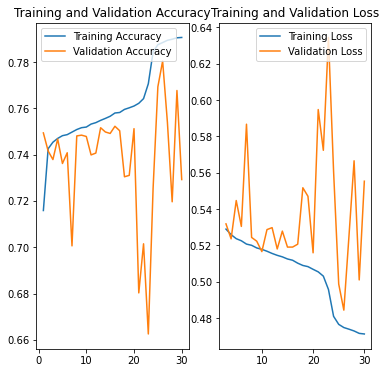

In [23]:
loss=history.history['loss']
val_loss=history.history['val_loss']

mae = history.history['accuracy']
val_mae = history.history['val_accuracy']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range[0:], mae[0:], label='Training Accuracy')
plt.plot(epochs_range[0:], val_mae[0:], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range[2:], loss[2:], label='Training Loss')
plt.plot(epochs_range[2:], val_loss[2:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
test_loss, test_acc = model.evaluate( [test['points'],test['features'],test['Glob_features']], test['label'], verbose=2, batch_size = batch_size)

196/196 - 6s - loss: 0.5560 - accuracy: 0.7292


In [27]:
model.load_weights("model_checkpoints/DGCNN_on_Tau_ptsNonAggiornato.h5")#DGCNN_on_Tau.h5 DGCNN_on_Tau_moreVar_tracks.h5

In [28]:
test_loss, test_acc = model.evaluate( [test['points'],test['features'],test['Glob_features']], test['label'], verbose=2, batch_size = batch_size)

196/196 - 6s - loss: 0.4881 - accuracy: 0.7776


### ROC curve

In [ ]:
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)

In [ ]:
predicted_data = model.predict([test['points'],test['features'],test['Glob_features']], batch_size = batch_size, verbose = 1)

In [ ]:
# calculate precision and recall
# True Positive
tp = len(test['label'][ (test['label'] == 0) & (predicted_data == 0) ])
# False Positive -- predict anomaly (-1), when it is actually normal (1)
fp = len(test['label'][(test['label'] == 1) & (predicted_data == 0)])
# True Negative
tn = len(test['label'][(test['label'] == 1) & (predicted_data == 1)])
# False Negative
fn = len(test['label'][(test['label'] == 0) & (predicted_data == 1)])

In [ ]:
# precision/recall
pre_score = tp / (tp + fp)
re_score = tp / (tp + fn)
# tpr/fpr
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

### Study of dataset

In [ ]:
%matplotlib notebook

In [ ]:
set_variable = ['DeltaEta', 'DeltaPhi', 'Pt', 'E', 'd0', 'z0', 'theta', 'Track-Flag']
mask = [-9, -9, -999, -999, -999, -999, -999, -9]
xlow = [-0.7, -0.7, 0, 0, 0]
xup = [0.7, 0.7, 10**9, 10**9, 4]
setted_var = 0 #btw 0 and 3
#cleaning of variable from mask and values bigger than 10**9
a = array_tau[:,:,setted_var]#
b = array_qcd[:,:,setted_var]#test['features']
c =  (a != mask[setted_var])
d =  (b != mask[setted_var])
a = a[c]
b = b[d]

n_bins=200
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
ax.hist(a, bins=n_bins , label=set_variable[setted_var]+'_tau', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
ax1.hist(b, bins=n_bins , label=set_variable[setted_var]+'_qcd', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
plt.title(set_variable[setted_var]+" of tau and qcd")
plt.xlabel(set_variable[setted_var])
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#ax.set_yscale('log')
#ax1.set_yscale('log')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))